## 4. Predicción de fugas de clientes en una compañía telefónica (7 puntos)

Una compañía telefónica está interesada en que desarrollemos un modelo que prediga los **100 clientes actuales** (dataset de explotaación) que tienen más probabilidad de abandonar la compañía. Para ello nos proporcionan una base de datos **fuga_clientes_empresa_telefonica_construccion.csv** con casos etiquetados, que usaremos para construir nuestro modelo de predicción.

Los campos de esta base de datos son:

* **Customer ID**

* **network_age**: antigüedad del cliente en días

* **Customer tenure in months:** antigüedad del cliente en meses

* **Total Spend in Months 1 and 2:** gasto total del cliente en los meses de referencia 1 y 2

* **Total SMS Spend:** gasto total en SMS

* **Total Data Spend:** gasto total en datos/internet

* **Total Data Consumption:** consumo total de datos (en KB) durante el período de estudio

* **Total Unique Calls:** número total de llamadas únicas

* **Total Onnet spend:** gasto total en llamadas a otros usuarios de la misma red de telefonía

* **Total Offnet spend:** gasto total en llamadas a otros usuarios de redes de telefonía diferentes

* **Total Call centre complaint calls:** número de llamadas de queja al call center

* **Network type subscription in Month 1:** suscripción de tipo de red en el mes 1. Esto indica la suscripción de red preferida de un cliente, lo que puede indicar su tipo de dispositivo: servicio 2G o 3G

* **Network type subscription in Month 2:** igual que el anterior pero en el mes posterior

* **Churn Status**: el valor es 1 si el cliente abandona la compañía telefónica, 0 si permanece en ella

* **Most Loved Competitor network in Month 1:** qué otro proveedor de la competencia prefiere el cliente en el mes 1. En realidad es un conjunto de columnas, cada una enfocada en un proveedor particular

* **Most Loved Competitor network in Month 2:** qué otro proveedor de la competencia prefiere el cliente en el mes 2. En realidad es un conjunto de columnas, cada una enfocada en un proveedor particular

La variable a predecir es **Churn Status**: el valor es 1 si el cliente **abandona** la compañía, 0 si no la abandona.

La compañía también nos proporciona otra base de datos, **fuga_clientes_empresa_telefonica_explotacion.csv**, con información sobre clientes de los que no se sabe ahora mismo si van a permanecer o no en la compañía. Por tanto en esta segunda base de datos todos los valores de la columna **Churn Status** son missing values (NaN).

La compañía nos pide que proporcionemos los IDs de los 100 clientes de la base de datos de explotación que con mayor probabilidad vayan a abandonar la compañía. Para ello proporcionaremos como entregable a la compañía un archivo csv con una sola columna, **Customer ID**, y 100 filas que contengan los IDs de los clientes seleccionados.

El fichero **ejemplo_fichero_predicciones.csv** contiene un ejemplo con el formato solicitado para este archivo.

In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import operator
import csv

In [2]:
datos_construccion = pd.read_csv("./fuga_clientes_empresa_telefonica_construccion.csv")
datos_explotacion  = pd.read_csv("./fuga_clientes_empresa_telefonica_explotacion.csv")

In [3]:
datos_construccion.columns

Index(['Customer ID', 'network_age', 'Customer tenure in month',
       'Total Spend in Months 1 and 2', 'Total SMS Spend', 'Total Data Spend',
       'Total Data Consumption', 'Total Unique Calls', 'Total Onnet spend',
       'Total Offnet spend', 'Total Call centre complaint calls',
       'Churn Status', 'Most Loved Competitor network in Month 1_0',
       'Most Loved Competitor network in Month 1_Mango',
       'Most Loved Competitor network in Month 1_PQza',
       'Most Loved Competitor network in Month 1_ToCall',
       'Most Loved Competitor network in Month 1_Uxaa',
       'Most Loved Competitor network in Month 1_Weematel',
       'Most Loved Competitor network in Month 1_Zintel',
       'Most Loved Competitor network in Month 2_Mango',
       'Most Loved Competitor network in Month 2_PQza',
       'Most Loved Competitor network in Month 2_ToCall',
       'Most Loved Competitor network in Month 2_Uxaa',
       'Most Loved Competitor network in Month 2_Weematel',
       'Most 

In [4]:
datos_explotacion.columns

Index(['Customer ID', 'network_age', 'Customer tenure in month',
       'Total Spend in Months 1 and 2', 'Total SMS Spend', 'Total Data Spend',
       'Total Data Consumption', 'Total Unique Calls', 'Total Onnet spend',
       'Total Offnet spend', 'Total Call centre complaint calls',
       'Churn Status', 'Most Loved Competitor network in Month 1_0',
       'Most Loved Competitor network in Month 1_Mango',
       'Most Loved Competitor network in Month 1_PQza',
       'Most Loved Competitor network in Month 1_ToCall',
       'Most Loved Competitor network in Month 1_Uxaa',
       'Most Loved Competitor network in Month 1_Weematel',
       'Most Loved Competitor network in Month 1_Zintel',
       'Most Loved Competitor network in Month 2_Mango',
       'Most Loved Competitor network in Month 2_PQza',
       'Most Loved Competitor network in Month 2_ToCall',
       'Most Loved Competitor network in Month 2_Uxaa',
       'Most Loved Competitor network in Month 2_Weematel',
       'Most 

In [5]:
# chequeo de que las columnas son exactamente las mismas en los dos ficheros:

sum(datos_construccion.columns != datos_explotacion.columns)

0

In [6]:
# la columna a predecir es "Churn Status"
# si es 1, el cliente se va de la compañía
# si es 0, el cliente se queda

# Esta columna se sabe en el dataset de construcción (ejemplos de clientes pasados):
datos_construccion["Churn Status"].values[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [7]:
# Sin embargo no se sabe en el dataset de explotación (clientes actuales):
datos_explotacion["Churn Status"].values[:10]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

## 1. Análisis de los datos

Una vez observados los atributos del conjunto de datos que se nos proporciona, nos disponemos a realizar un análisis de la sección de entrenamiento (fuga_clientes_empresa_telefonica_construccion.csv). En este apartado visualizaremos los atributos y sus relaciones. Esto nos servirá para modificar el dataset de la forma en la que creamos conveniente según las relaciones que hayamos obtenido. Una vez modificado el dataset, comprobaremos que tál entrenan estos datos y podremos pasar a la siguiente parte del problema.

In [8]:
# primero observamos cuantas filas(ejemplos) y columnas(atributos) existen en el dataset
print('Ejemplos: {}'.format(datos_construccion.shape[0]))
print('Atributos: {} \n'.format(datos_construccion.shape[1]))

Ejemplos: 1110
Atributos: 25 



In [9]:
# también nos interesan saber los tipos de datos de cada columna
print(datos_construccion.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 25 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Customer ID                                        1110 non-null   object 
 1   network_age                                        1110 non-null   int64  
 2   Customer tenure in month                           1110 non-null   float64
 3   Total Spend in Months 1 and 2                      1110 non-null   float64
 4   Total SMS Spend                                    1110 non-null   float64
 5   Total Data Spend                                   1110 non-null   float64
 6   Total Data Consumption                             1110 non-null   float64
 7   Total Unique Calls                                 1110 non-null   int64  
 8   Total Onnet spend                                  1110 non-null   int64  
 9   Total Of

Al analizar los resultados de la sentencia ejecutada, se puede obsevar que toda las columnas están llenas y no hay ningún missing value, usaremos otros métodos para saber qué atributos son los más importantes.

In [10]:
# visualización de los datos de forma "bonita" y más legible
pd.set_option("display.max.columns", None)
display(datos_construccion.head())

,Customer ID,network_age,Customer tenure in month,Total Spend in Months 1 and 2,Total SMS Spend,Total Data Spend,Total Data Consumption,Total Unique Calls,Total Onnet spend,Total Offnet spend,Total Call centre complaint calls,Churn Status,Most Loved Competitor network in Month 1_0,Most Loved Competitor network in Month 1_Mango,Most Loved Competitor network in Month 1_PQza,Most Loved Competitor network in Month 1_ToCall,Most Loved Competitor network in Month 1_Uxaa,Most Loved Competitor network in Month 1_Weematel,Most Loved Competitor network in Month 1_Zintel,Most Loved Competitor network in Month 2_Mango,Most Loved Competitor network in Month 2_PQza,Most Loved Competitor network in Month 2_ToCall,Most Loved Competitor network in Month 2_Uxaa,Most Loved Competitor network in Month 2_Weematel,Most Loved Competitor network in Month 2_Zintel
0,ADF0039,123,4.10,76.7140,0.00,1.25,1.4951,14,564,6408,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,ADF0041,1316,43.87,98.8904,4.14,1.25,1.0244,27,1626,4373,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,ADF0051,2385,79.50,372.6300,3.51,1.25,6.0898,119,10411,22039,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,ADF0059,1614,53.80,530.2000,6.85,1.25,3.3447,69,6822,6274,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,ADF0060,2175,72.50,554.1300,6.99,153.75,673204.0342,33,3387,7241,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0


Lo primero que haremos será agrupar los datos de tipo númerico y observamos sus correlaciones. En este caso, serán todos los datos, menos el ID del cliente.

In [11]:
# tipos de datos en concreto
print(list(set(datos_construccion.dtypes.tolist())))

# almacenamos en dataframe, estos datos
datos_contruccion_num = datos_construccion.select_dtypes(include = ['float64', 'int64'])

# display de los datos
pd.set_option("display.max.columns", None)
display(datos_contruccion_num.head())

[dtype('int64'), dtype('O'), dtype('float64')]


,network_age,Customer tenure in month,Total Spend in Months 1 and 2,Total SMS Spend,Total Data Spend,Total Data Consumption,Total Unique Calls,Total Onnet spend,Total Offnet spend,Total Call centre complaint calls,Churn Status,Most Loved Competitor network in Month 1_0,Most Loved Competitor network in Month 1_Mango,Most Loved Competitor network in Month 1_PQza,Most Loved Competitor network in Month 1_ToCall,Most Loved Competitor network in Month 1_Uxaa,Most Loved Competitor network in Month 1_Weematel,Most Loved Competitor network in Month 1_Zintel,Most Loved Competitor network in Month 2_Mango,Most Loved Competitor network in Month 2_PQza,Most Loved Competitor network in Month 2_ToCall,Most Loved Competitor network in Month 2_Uxaa,Most Loved Competitor network in Month 2_Weematel,Most Loved Competitor network in Month 2_Zintel
0,123,4.10,76.7140,0.00,1.25,1.4951,14,564,6408,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,1316,43.87,98.8904,4.14,1.25,1.0244,27,1626,4373,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,2385,79.50,372.6300,3.51,1.25,6.0898,119,10411,22039,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,1614,53.80,530.2000,6.85,1.25,3.3447,69,6822,6274,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,2175,72.50,554.1300,6.99,153.75,673204.0342,33,3387,7241,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0


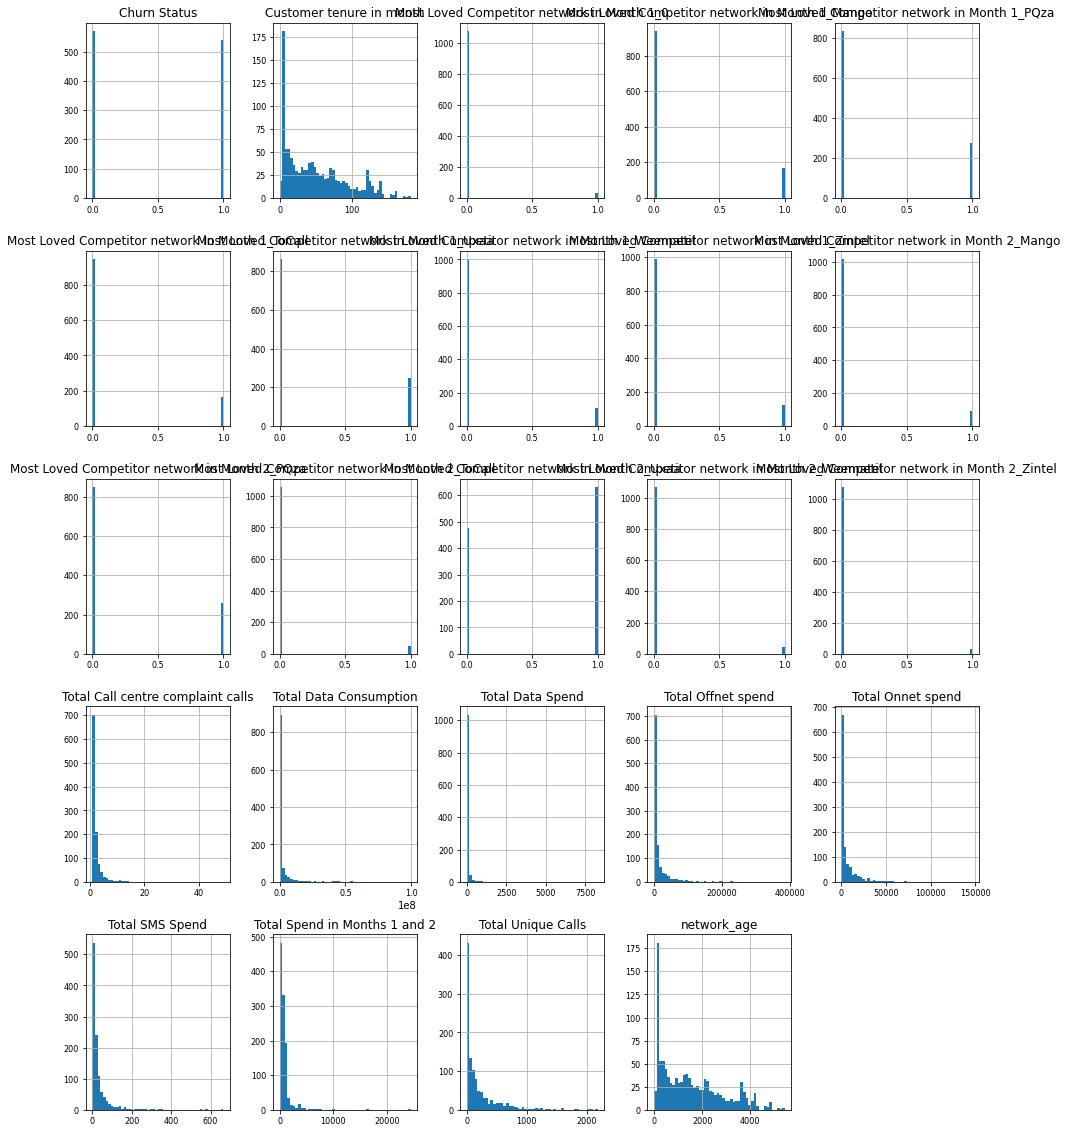

In [12]:
# plot de los datos numéricos
datos_contruccion_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Es complicado identificar qué atributo corresponde con cada gráfica pero al observarlo son más cautela lo hemos conseguido sacar. Indicamos las correspondencias en el siguiente texto:

* fila 1: Churn Status, Customer tenure in month, Most Loved Competitor network in Month 1_0, Most Loved Competitor network in Month 1_Mango, Most Loved Competitor network in Month 1_PQza


* fila 2: Most Loved Competitor network in Month 1_ToCall, Most Loved Competitor network in Month 1_Uxaa, Most Loved Competitor network in Month 1_Weematel, Most Loved Competitor network in Month 1_Zintel, Most Loved Competitor network in Month 2_Mango


* fila 3: Most Loved Competitor network in Month 2_PQza, Most Loved Competitor network in Month 2_ToCall, Most Loved Competitor network in Month 2_Uxaa, Most Loved Competitor network in Month 2_Weematel, Most Loved Competitor network in Month 2_Zintel


* fila 4: Total Call centre complaint calls, Total Data Consumption, Total Data Spend, Total Offnet spend, Total Onnet spend


* fila 5: Total SMS Spend, Total Spend in Months 1 and 2, Total Unique Calls, network_age

A simple vista, no podemos descartar atributos, ya que además no hay valores no disponibles en el dataset. Lo que haremos será observar las correlaciones entre distintos atributos.

In [13]:
# creamos dataframe para las correlaciones con network_age
df_corr_network_age = datos_contruccion_num.corr()['network_age'][:-1]
# cogemos los valores que tean una correlación > 0.5
correlaciones_network_age = df_corr_network_age[abs(df_corr_network_age) > 0.5].sort_values(ascending=False)
print("Existen {} correlaciones con network_age:\n{}".format(len(correlaciones_network_age), correlaciones_network_age))

Existen 2 correlaciones con network_age:
network_age                 1.0
Customer tenure in month    1.0
Name: network_age, dtype: float64


Podemos observar que los atributos network_age y Customer tenure in month están muy correlacionadas y podríamos eliminar una de ellas del dataset. Esto lo podríamos ver a simple vista observando los significados de los atributos (ya que los dos indican lo mismo pero en distintas medidas). Sin embargo, es mejor práctica comprobarlo y tener la certeza de que estamos borrando algo que de verdad no nos es útil. Con el código previo, hemos comprobado con demás atributos por si había alguna otra correlación que nos permitiera descartar más atributos. Los únicos que hemos observado que tienen una correlación tan alta son los previamente mencionados. Cuando finalice el análisis, borraremos una de estas dos columnas, la que menos relación tenga con la clase (Churn Status).

Ahora nos disponemos a comprobar las correlaciones con Churn Status.

In [14]:
# creamos dataframe para las correlaciones con la clase
df_corr_class = datos_contruccion_num.corr()['Churn Status'][:-1]
# cogemos los valores que tean una correlación cistinta de cero
correlaciones_clase = df_corr_class[abs(df_corr_class) != 0].sort_values(ascending=False)
print("Existen {} correlaciones con Churn Status:\n{}".format(len(correlaciones_clase), correlaciones_clase))

Existen 23 correlaciones con Churn Status:
Churn Status                                         1.000000
Most Loved Competitor network in Month 2_PQza        0.235395
Total SMS Spend                                      0.151406
Most Loved Competitor network in Month 1_PQza        0.127392
Total Offnet spend                                   0.117207
Most Loved Competitor network in Month 2_Mango       0.113278
Most Loved Competitor network in Month 2_ToCall      0.112127
Most Loved Competitor network in Month 2_Weematel    0.081296
Most Loved Competitor network in Month 1_Mango       0.064736
Total Data Spend                                     0.045740
Total Spend in Months 1 and 2                       -0.020870
Most Loved Competitor network in Month 1_ToCall     -0.028923
Total Onnet spend                                   -0.038664
Most Loved Competitor network in Month 1_Weematel   -0.042494
Most Loved Competitor network in Month 1_Zintel     -0.056427
Most Loved Competitor netwo

Hemos observado todas las correlaciones con la clase del dataset. Se puede observar que la mayoría tienen alguna relación y lo mejor sería descartar una de las que hemos mencionado antes. En este caso, eliminaremos del dataset la columna network_age ya que está algo menos correlacionada con la clase.

## 2. Preparación de los datos

Una vez analizados los datos y sacadas unas conclusiones sobre ellos, modificaremos los dataframes que tengamos que usar. También probaremos distintos clasificadores y elegiremos el que mejor resultados nos de sin tratar de sobre-ajustar los datos. Hemos decidido eliminar la columna Customer ID de los dataframes ya que es información que no nos hace falta a la hora de clasificar. Guardamos esta columna en una lista para posteriormente trabajar con ella y las probabilidades que obtengamos.

In [15]:
# drop de la columna network_age en datos_construcción
datos_construccion.drop(['network_age'], axis='columns', inplace=True)
# drop de las columnas no numéricas
datos_construccion.drop(['Customer ID'], axis='columns', inplace=True)

# drop de la columna network_age en datos_explotación
datos_explotacion.drop(['network_age'], axis='columns', inplace=True)
# guardamos en una lista auxiliar los IDs ya que nos harán falta para asignarlo a cada probabilidad
customer_IDs = datos_explotacion['Customer ID'].tolist()
# drop de las columnas no numéricas
datos_explotacion.drop(['Customer ID'], axis='columns', inplace=True)

In [16]:
#comprobamos que ahora hay una columna menos (antes había 25)
print('Atributos: {} \n'.format(datos_construccion.shape[1]))

Atributos: 23 



In [17]:
# lista de atributos del dataset
attrs = list(datos_construccion.columns)
# no incluimos la clase en la X
attrs.remove('Churn Status')
X_train = datos_construccion[attrs].values
# metemos la clase en la y
y_train = datos_construccion['Churn Status'].values
# creamos el clasificador
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 4)
# MLPClassifier(hidden_layer_sizes = (200,100), max_iter = 1000, alpha = 0)
# KNeighborsClassifier(n_neighbors = 3)
# usamos validación cruzada con 5 folds
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Score global del modelo: {:.2f} +/- {:.2f}".format(scores.mean(), scores.std()))

Score global del modelo: 0.74 +/- 0.05


Hemos realizado varias pruebas con distintos modelos de clasificación y el que mejor resultados nos daba es Árbol de Decisión. Hemos incluido una profundidad máxima de 4 para asegurarnos de que no causa sobre-ajuste. Si le metiéramos un valor más grande, es probable que obtenga mejores scores pero no se estaría ajustando a la realidad. Las conclusiones sobre qué modelo usar y sus parámetros indicados las hemos sacado también de ejercicios previos en los notebooks 1 y 2.

## Predicción de las probabilidades para cada cliente

Una vez decidido el modelo que utilizaremos y los datos estén ya preparados, nos disponemos a calcular las probabilidades de que cada cliente se fugue de la empresa.

In [18]:
# preparación de los datos de test
atributos = list(datos_explotacion.columns)
atributos.remove('Churn Status')
X_test = datos_explotacion[atributos].values
y_test = datos_explotacion['Churn Status'].values

# realizamos el fit con el modelo elegido previamente
clf.fit(X_train, y_train)
# sacamos probabilidades con los datos de test(explotacion)
probs = clf.predict_proba(X_test)[:, 1]

# ahora en la lista "probs" tenemos la probabilidad asociada a cada cliente 
# cada cliente en ese orden está en la lista "customer_IDs"
lista_tuplas = []
for i, id_cliente in enumerate(customer_IDs):
    # guardamos en la lista tuplas que contienes el ID del cliente y su probabilidad de fuga
    lista_tuplas.append((id_cliente, probs.tolist()[i]))
    
# ordenamos la lista de tuplas por el segundo valor(probabilidad)
# reverse = True para que se ordene de mayor a menor
sorted_by_prob = sorted(lista_tuplas, key=lambda tup: tup[1], reverse = True)

# lista que contendrá los IDs de los 100 más probables que se fuguen
# ORDENADA DE MAYOR A MENOR PROBABILIDAD
list100IDS = []

for j, (customer_id, prob) in enumerate(sorted_by_prob):
    # cogemos solo los 100 primeros con mayor prob
    if j== 100:
        break
    list100IDS.append(customer_id)

# guardamos lista en csv
df = pd.DataFrame(list100IDS, columns=["Customer ID"])
df.to_csv('RESULTADOS.csv', index = False)
display(df)

,Customer ID
0,ADF1560
1,ADF1561
2,ADF1563
3,ADF1564
4,ADF1567
...,...
95,ADF0524
96,ADF0042
97,ADF0256
98,ADF0262
